# Topic modeling v2

In this notebook, we will start again our work to get topics from posts.  
The reason of this change is simple : 
* There are a lot of pre-processing actions we could do to improve our initial dataset (lemmatization, group words together, filter words,...)
* Our LDA model we used before got us an error we couldn't fix. This time, based on a new course (https://www.youtube.com/watch?v=6zm9NC9uRkk&ab_channel=PyData), we will improve our code.

Let's begin

## Import the data

In [1]:
import pandas as pd
import pickle
import numpy as np

In [2]:
data = pd.read_pickle("contentCorpus.pkl")
data

,Name,#Reactions,#Comments,Location,Followers,Time_spent,Media_type,Content
0,Nicholas Wyman,12,1,Unknown,6484.0,1 day ago,article,robert lerman writes that achieving a healthy...
1,Nicholas Wyman,11,0,Unknown,6484.0,1 week ago,none,"national disability advocate sara hart weir, ..."
3,Nicholas Wyman,44,0,Unknown,6484.0,2 months ago,article,exploring in this months talent management & h...
4,Nicholas Wyman,22,2,Unknown,6484.0,2 months ago,article,i count myself fortunate to have spent time wi...
5,Nicholas Wyman,21,1,Unknown,6484.0,2 months ago,article,online job platforms are a different way of wo...
...,...,...,...,...,...,...,...,...
34007,Simon Sinek,4005,93,Unknown,4206024.0,4 years ago,image,igniter of the year 2016. well i know that i'm...
34008,Simon Sinek,1698,74,Unknown,4206024.0,4 years ago,video,executives who prioritize the shareholder are ...
34009,Simon Sinek,661,59,Unknown,4206024.0,4 years ago,video,"like many, i too have been reflecting as we ne..."
34010,Simon Sinek,766,35,Unknown,4206024.0,4 years ago,video,"if you say ""customer first"" that means your em..."


In [3]:
# Let's devide this dataset into two datasets : Corpus only & Informations about the post

# We create a specific ID for each row
data["ID"]=range(data.shape[0])

# We create the dataset containing content
corpus = data[['ID','Content']]

# And the one containing reactions & comments about each post
# We don't need other columns for this analysis
postReactions = data[['ID','#Reactions','#Comments']]

In [4]:
for c in corpus['Content'][[1,100,1000,10000,20000]]:
    print(c)
    print('--------------')

national disability advocate  sara hart weir, ms   shares how congress passed the able act
--------------
for those intersted in youth career pathways. great to read today about the expansion of citi foundation’s pathways to progress inititiave - new commitment to 500k young adults #jobready #jobs #training  joanne gedge   janet searle   louise martin lindsay   amy-lou cowdroy-ling   https://lnkd.in/g8ftr5w. 
--------------
community building has meant something dramatically different the past couple of months.  when 500 startups hosted an event with 2400+ rsvps, we had to pivot almost 8 times to accommodate changing restrictions along the way.  people are rallying around their communities to show support for groups like healthcare workers while staying in their homes for months.  all these things have made me ask the question, what's the best way to build community right now? how is this changing our perception of community? thus, i'm starting my letter to the community on the subject

As we can see, some words can be filtered :
* mentions (joanne gedge, janet searle,...)
* some hashtags that are involved in sentences (natgeotraveller , globalhealth), generally at the end of the post

## Texts Preprocessing : what we can do ?

For this preprocessing, we will use Spacy, which is a fast industrial-strength natural language processing (NLP) library for Python.

spaCy handles many tasks commonly associated with building an end-to-end natural language processing pipeline:

* Tokenization
* Text normalization, such as lowercasing, stemming/lemmatization
* Part-of-speech tagging
* Syntactic dependency parsing
* Sentence boundary detection
* Named entity recognition and annotation

In the "batteries included" Python tradition, spaCy contains built-in data and models which you can use out-of-the-box for processing general-purpose English language text:

* Large English vocabulary, including stopword lists
* Token "probabilities"
* Word vectors

In [5]:
import spacy
import codecs

# We need to import spacy trained pipelines, which support many languages
# Let's use the English pipeline

# In CMD :
# $ python -m spacy download en_core_web_lg
# or
# In python :
# >>> import spacy
# >>> nlp = spacy.load("en_core_web_lg")

# We download the large version "lg" and not the small version "sm" here 
# This module is pretty large : ~631 MB
nlp = spacy.load("en_core_web_lg")

Let's create a sample of several posts to play with.

In [6]:
#Posts are separated by line breaks, and gather into one string
posts_sample = "\n\n".join(corpus.Content[[1,100,1000,10000,20000]])

print(posts_sample)

national disability advocate  sara hart weir, ms   shares how congress passed the able act

for those intersted in youth career pathways. great to read today about the expansion of citi foundation’s pathways to progress inititiave - new commitment to 500k young adults #jobready #jobs #training  joanne gedge   janet searle   louise martin lindsay   amy-lou cowdroy-ling   https://lnkd.in/g8ftr5w. 

community building has meant something dramatically different the past couple of months.  when 500 startups hosted an event with 2400+ rsvps, we had to pivot almost 8 times to accommodate changing restrictions along the way.  people are rallying around their communities to show support for groups like healthcare workers while staying in their homes for months.  all these things have made me ask the question, what's the best way to build community right now? how is this changing our perception of community? thus, i'm starting my letter to the community on the subject. 

where can we find  #case

In [7]:
parsed_posts_sample = nlp(posts_sample)

print(parsed_posts_sample)

national disability advocate  sara hart weir, ms   shares how congress passed the able act

for those intersted in youth career pathways. great to read today about the expansion of citi foundation’s pathways to progress inititiave - new commitment to 500k young adults #jobready #jobs #training  joanne gedge   janet searle   louise martin lindsay   amy-lou cowdroy-ling   https://lnkd.in/g8ftr5w. 

community building has meant something dramatically different the past couple of months.  when 500 startups hosted an event with 2400+ rsvps, we had to pivot almost 8 times to accommodate changing restrictions along the way.  people are rallying around their communities to show support for groups like healthcare workers while staying in their homes for months.  all these things have made me ask the question, what's the best way to build community right now? how is this changing our perception of community? thus, i'm starting my letter to the community on the subject. 

where can we find  #case

Looks the same ! So what happened ?  
Let's apply some functions !

### Sentences detection

Actually, we have already removed punctuation, but it is working very well !!!  
I keep that here for a later use. 

In [8]:
for num, sentence in enumerate(parsed_posts_sample.sents):
    print("Sentence {}".format(num+1))
    print(sentence)
    print('')

Sentence 1
national disability advocate  sara hart weir, ms   shares how congress passed the able act

for those intersted in youth career pathways.

Sentence 2
great to read today about the expansion of citi foundation’s pathways to progress inititiave - new commitment to 500k young adults #jobready #jobs #training  joanne gedge   janet searle   louise martin lindsay   amy-lou cowdroy-ling   https://lnkd.in/g8ftr5w.

Sentence 3


community building has meant something dramatically different the past couple of months.

Sentence 4
 when 500 startups hosted an event with 2400+ rsvps, we had to pivot almost 8 times to accommodate changing restrictions along the way.

Sentence 5
 people are rallying around their communities to show support for groups like healthcare workers while staying in their homes for months.

Sentence 6
 all these things have made me ask the question, what's the best way to build community right now?

Sentence 7
how is this changing our perception of community?

Sent

In [9]:
# Same with the original content, containing ponctuations & uppercases
test = pd.read_pickle("cleaned_data.pkl")
test_content = test.content
sample_test_content = "\n\n".join(test_content[[100,1000]])
parsed_sample_test = nlp(sample_test_content)

for num, sentence in enumerate(parsed_sample_test.sents):
    print("Sentence {}".format(num+1))
    print(sentence)
    print('')

Sentence 1
For those intersted in youth career pathways.

Sentence 2
Great to read today about the expansion of Citi Foundation’s Pathways to Progress inititiave - new commitment to 500k young adults #JobReady #Jobs #Training  Joanne Gedge   Janet Searle   Louise Martin Lindsay   Amy-Lou Cowdroy-Ling   https://lnkd.in/g8FTr5w.

Sentence 3

 
 
 …see more

Community building has meant something dramatically different the past couple of months.

Sentence 4
 When 500 Startups hosted an event with 2400+ RSVPs, we had to pivot almost 8 times to accommodate changing restrictions along the way.

Sentence 5
 People are rallying around their communities to show support for groups like healthcare workers while staying in their homes for months.

Sentence 6
 All these things have made me ask the question, what's the best way to build community right now?

Sentence 7
How is this changing our perception of community?

Sentence 8
Thus, I'm starting my letter to the community on the subject.

Sentenc

### 

### Name entity detection

In [10]:
for num, entity in enumerate(parsed_posts_sample.ents):
    print("Entity {}".format(num+1), entity, '-', entity.label_)

Entity 1 congress - ORG
Entity 2 today - DATE
Entity 3 citi foundation’s - ORG
Entity 4 500k - ORG
Entity 5 joanne gedge   janet searle   louise martin lindsay   amy-lou cowdroy-ling - PERSON
Entity 6 the past couple of months - DATE
Entity 7 500 - CARDINAL
Entity 8 2400 - CARDINAL
Entity 9 8 - CARDINAL
Entity 10 months - DATE
Entity 11 u.s. - GPE
Entity 12 atlanta - GPE
Entity 13 one - CARDINAL
Entity 14 12th - ORDINAL
Entity 15 linkedin fam - PERSON


* ORG : organism 
* GPE : geopolitcal entity
* LOC : location

As we can see, we can know which entity represents each words or group of words ! 

For instance, spacy knows when a group of words is a name, a location, a date ...  
That's clearly amazing !

Also, it appears that some words are badly comprehend by the algorithm like "us", as USA, which is here "us" designating we.


### Speech tagging

We can also define if a word is an adjective, a noun, or other...

In [11]:
token_text = [token.orth_ for token in parsed_posts_sample]
token_pos = [token.pos_ for token in parsed_posts_sample]

pd.DataFrame({"Token_text" : token_text , "Token_pos" : token_pos})

,Token_text,Token_pos
0,national,ADJ
1,disability,NOUN
2,advocate,NOUN
3,,SPACE
4,sara,PROPN
...,...,...
355,!,PUNCT
356,#,SYM
357,natgeotraveller,NOUN
358,#,NOUN


### Text normalization (stemming/lemmatization and shape analysis)

Lemmatization consists in transforming a word into its root. 

For instance, "is" becomes "be" ; "me" becomes "I" ...

In [12]:
token_lemma = [token.lemma_ for token in parsed_posts_sample]
token_shape = [token.shape_ for token in parsed_posts_sample]

pd.DataFrame({'Token_text' : token_text, 'Token_lemma' : token_lemma , 'Token_shape' : token_shape})

,Token_text,Token_lemma,Token_shape
0,national,national,xxxx
1,disability,disability,xxxx
2,advocate,advocate,xxxx
3,,,
4,sara,sara,xxxx
...,...,...,...
355,!,!,!
356,#,#,#
357,natgeotraveller,natgeotraveller,xxxx
358,#,#,#


What about a variety of other token-level attributes, such as the relative frequency of tokens, and whether or not a token matches any of these categories?

* stopword
* punctuation
* whitespace
* represents a number
* whether or not the token is included in spaCy's default vocabulary?

In [13]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_posts_sample]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))

df

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,national,-20.0,,,,,
1,disability,-20.0,,,,,
2,advocate,-20.0,,,,,
3,,-20.0,,,Yes,,Yes
4,sara,-20.0,,,,,
...,...,...,...,...,...,...,...
355,!,-20.0,,Yes,,,
356,#,-20.0,,Yes,,,
357,natgeotraveller,-20.0,,,,,Yes
358,#,-20.0,,Yes,,,


* Log_probability represents the frequency of a word apparation in the text : 
    *  ~ 0 if appears often
    * =! 0 if appears rarely 
    

* Stop ? : Is this word a stop word ?

* Out of vocab ? : Is this word out of the english dictionary proposed by Spacy


## NLP preprocessing : application

## First pre-processing

In this section, we will clean a little bit the content by removing hashtags. Indeed, it appears that some hastags have no sense for future models.

In [14]:
# Let's create a function to apply to the pd.Serie
def rm_hashtags(str):
    return " ".join(word for word in str.split(' ') if "#" not in word)

first_clean_corpus = corpus['Content'].apply(rm_hashtags)

print("Cleaned !:")
print("----------")

for post in first_clean_corpus[:4]:
    print(post)
    print("")

Cleaned !:
----------
robert lerman  writes that achieving a healthy future of work requires employees to build skills that help them attain productive and rewarding careers. he notes - "one of the most cost-effective ways to do this is through apprenticeship, which helps workers master occupations and gain professional identity and pride". coudlnt agree more!        read the article on    urban institute 

national disability advocate  sara hart weir, ms   shares how congress passed the able act

exploring in this months talent management & hr what a company should consider to get the most out of a modern apprenticeship program. thanks to employer & entrepreneuer  ankur gopal  for sharing insights on your it program.  why not start a program in 2021.. wishing you all a safe and happy festive season.  nick          urban institute   zach boren   robert lerman   lana gordon   andrew sezonov   simon w.   ervin dimeny 

i count myself fortunate to have spent time with brooklyn-born arnold

### Phrase modeling

Phrase modeling is another approach to learning combinations of tokens that together represent meaningful multi-word concepts. We can develop phrase models by looping over the the words in our reviews and looking for words that co-occur (i.e., appear one after another) together much more frequently than you would expect them to by random chance. The formula our phrase models will use to determine whether two tokens  and  constitute a phrase is:

$$ \frac{count (AB) - count_{min}}{count(A)*count(B)} * N > treshold $$

 
...where:

 * $count(A)$ is the number of times token $A$ appears in the corpus
 * $count(B)$ is the number of times token $B$ appears in the corpus
 * $count(AB)$ is the number of times the tokens $AB$ appear in the corpus in order
 * $N$ is the total size of the corpus vocabulary
 * $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
 * $treshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase
Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token.

Phrase modeling is superficially similar to named entity detection in that you would expect named entities to become phrases in the model (so new york would become new_york). But you would also expect multi-word expressions that represent common concepts, but aren't specifically named entities (such as happy hour) to also become phrases in the model.

We turn to the indispensible **gensim** library to help us with phrase modeling — the Phrases class in particular.

In [15]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import itertools as it

As we're performing phrase modeling, we'll be doing some iterative data transformation at the same time. Our roadmap for data preparation includes:

* Segment text of complete reviews into sentences & normalize text
* First-order phrase modeling  apply first-order phrase model to transform sentences
* Second-order phrase modeling  apply second-order phrase model to transform sentences
* Apply text normalization and second-order phrase model to text of complete reviews
* We'll use this transformed data as the input for some higher-level modeling approaches in the following sections.

First, let's define a few helper functions that we'll use for text normalization. In particular, the **lemmatized_sentence_corpus** generator function will use spaCy to:

In [16]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_punct or token.is_space

def rules(token):
    """
    conditions to select a specific token for the corpus cleaning
    used with all() function : return True if all True
    """

    return [not punct_space(token),
            token not in nlp.Defaults.stop_words,
            token.pos_ == 'NOUN' or token.pos_ =="ADJ"]
            
def corpus_cleaning(serie):
    """
    generator function to use spaCy to parse posts,
    lemmatize the text, remove punctuations, unconvenient whitespaces, stopwords, and
    keep only nouns and adjectives
    """
    
    for post in nlp.pipe(serie):
      yield ' '.join([ token.lemma_ for token in post if all(rules(token)) ])

*Update*

At first, we have decided to keep verbs. However it appears that verbs like "go" or "be" appeared significantly in the topic modeling later. Therefore we will just keep Nouns & Adjectives

**Note**

"yield" returns the value we ask him, but in opposite to "return", it saves the last value it returned. Therefore, in our case, it returns a "list" of posts, whereas "return" would return one string *''.join()* of words.

Let's see if the cleaning is good !

In [17]:
print("Original :")

for post in it.islice(corpus_cleaning(first_clean_corpus),4):
    print(post)
    print('')

print("Cleaned :")

for post in it.islice(corpus_cleaning(first_clean_corpus),4):
    print(post)
    print("")

Original :
write healthy future work employee skill productive rewarding career cost effective way apprenticeship worker master occupation professional identity pride article

national disability advocate ms share able act

month talent management hr company most modern apprenticeship program thank employer entrepreneuer insight program program safe happy festive season dimeny

fortunate time assistant secretary policy evaluation research labor administration insight innovative thinking economic employment training policy many people young people full potential aged last project colleage resume thank institute report lerman lopr wonderful insight topic love thought conversation safe

Cleaned :
write healthy future work employee skill productive rewarding career cost effective way apprenticeship worker master occupation professional identity pride article

national disability advocate ms share able act

month talent management hr company most modern apprenticeship program thank employer

Here we used *yield* instead of *return*.  
The reason is well explained here : https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

Long story short, *yield* returns a generator, which is an iterable, as a list or a string for instance, but does not store all the values in the memory.

Generators recquire less memory than a list that is very useful if the dataset is very large !

Therefore, **we can only iterate over once**. 

To understand how to use spacy with a pandas, here a clearly explained article : https://towardsdatascience.com/structured-natural-language-processing-with-pandas-and-spacy-7089e66d2b10

We first need to apply the spaCy language model to the entire collection of posts. The easiest and most computationally efficient way to do this is to use the *nlp.pipe* function. This will iterate over each document and will apply the language model.

In [18]:
#Let's apply the function *CorpusCleaning* to create a parsed list
cleaned_posts = corpus_cleaning(first_clean_corpus)
print(type(cleaned_posts))

#We can print cleaned posts with 
#list(parsed_posts)
#But it's time consuming

<class 'generator'>


Let's see some examples.

To iterate on a generator, we can use the *itertools* package, which is a common practice with generator objects.

it.islice is an iterator designed to iterate over an object. Because we can't iterate directly over a generator (can't be subscriptable), this function is pretty useful !

In [19]:
for post in it.islice(cleaned_posts,5):
    print(post)
    print(type(post))
    print('----')

write healthy future work employee skill productive rewarding career cost effective way apprenticeship worker master occupation professional identity pride article
<class 'str'>
----
national disability advocate ms share able act
<class 'str'>
----
month talent management hr company most modern apprenticeship program thank employer entrepreneuer insight program program safe happy festive season dimeny
<class 'str'>
----
fortunate time assistant secretary policy evaluation research labor administration insight innovative thinking economic employment training policy many people young people full potential aged last project colleage resume thank institute report lerman lopr wonderful insight topic love thought conversation safe
<class 'str'>
----
online job platform different way time workplace school international border example future work conversation
<class 'str'>
----


**Important note**

When we iterate over a generator, the value saved in it is then deleted ! 

That confirms the definition of a generator : we can only iterate over it once !

**That also means if we want to use several times a generator, we have to recreate one for the purpose !**

For instance, here, we can't use anymore the 6 first values contained in the generator !

A common practice consists in iterating on a generator in this way :

```
for i in create_a_generator_function(y):   
    print(i)
```

******

Now, let's group words together with the **gensim.models.Phrases** library.

In [20]:
%%time
# Filename of the model allowing us to join words together
filename = 'bigram_model.pkl'

# This code was long to run
# Make the folloing statement true if you want to run it again
if 0 == 1:

    # Let's generate the cleaned content one more time as a generator
    # It can be used only one time, so we have to be careful to save the modified version
    cleaned_posts = corpus_cleaning(first_clean_corpus)

    # gensim.Phrases needs a sequence of sentences. (e.g. an iterable or a generator)
    # Each sentence has to be a list of string tokens
    streamed_posts = (post.split(' ') for post in cleaned_posts)

    # We train the model
    # min_count : the minimum of sentences (aka. coupled words) found in the doc. Under this value, the model doesn't take it into consideration.
    # treshold : (by default : 10). The higher, the fewer phrases.
    # This line return a model we can use later. 
    bigram_model = Phrases(streamed_posts,min_count=5,threshold=10)

    # Save the model for later use
    pickle.dump(bigram_model, open(filename, 'wb'))

# Load the model if the statement is False
bigram_model = pickle.load(open(filename, 'rb'))

Wall time: 234 ms


In [21]:
# How many sentences were found ? / Which words were associated in the doc ?
# pd.DataFrame(data = bigram_model.export_phrases(), columns=[['Phrases',"Score"]])

# model.export_phrases() return a dict with phrases as keys and scores as values
# score represents the frequency of apparition in doc, following the previous formula :
phrases = bigram_model.export_phrases()

pd.DataFrame(data = {"Phrases" : phrases.keys() , "Score" : phrases.values()})

,Phrases,Score
0,cost_effective,31.947798
1,apprenticeship_program,57.727183
2,festive_season,149.195370
3,young_people,11.238823
4,full_potential,29.053028
...,...,...
2193,infinite_mindset,113.322901
2194,bit_optimism,233.523188
2195,optimism_podcast,42.723320
2196,worthy_rival,434.901484


$$ score(A,B) = \frac{count(AB)-min_{AB}}{count(A)*count(B)} $$

**Notes**

We see that some phrases have a huge score. 

Let's check these posts.

*Update : by removing hashtags at the begining, we avoid this issue*

In [22]:
# text ='startwithwhy'
# serie = corpus.Content

# for post in serie.loc[serie.str.contains(text, regex=False)]:
#     print(post)
#     print("....")


Indeed, some words are associated together because they are written together in the hashtags "section".  

It would be maybe useful to remove hashtags from all posts to avoid this issue.

*Update : that is what we have done*

**Now we have defined *bigram phrases*, we can apply the model to the corpus !**

In [23]:
%%time
# Filename of the model allowing us to join words together
filename = 'bigram_corpus.pkl'

# This code was long to run
# Make the folloing statement true if you want to run it again
if 0 == 1:

    # We re-create from the first_clean_corpus a sequence of posts, each of them tokenized (words are splitted)
    cleaned_posts = corpus_cleaning(first_clean_corpus)
    streamed_posts = (post.split(' ') for post in cleaned_posts)

    # We create a new list of cleaned posts we will use for future models
    bigram_corpus = []

    for streamed_post in streamed_posts:
        bigram_post = ' '.join(bigram_model[streamed_post])
        bigram_corpus.append(bigram_post)

    bigram_corpus   

    # Save the corpus for later use
    pickle.dump(bigram_corpus, open(filename, 'wb'))

# Load the model if the statement is False
bigram_corpus = pickle.load(open(filename, 'rb'))

Wall time: 21.9 ms


**J'AI REUSSI !!!!!!!**

## Topic modeling with Latent Dirichlet Allocation (LDA)

Now we have succesfully cleaned the corpus, removed hashtags, selected only relevant words, and associated words together, we can now apply a model to define topics in all these posts. 

Topic modeling is family of techniques that can be used to describe and summarize the documents in a corpus according to a set of latent "topics". For this demo, we'll be using Latent Dirichlet Allocation or LDA, a popular approach to topic modeling.

In many conventional NLP applications, documents are represented a mixture of the individual tokens (words and phrases) they contain. In other words, a document is represented as a vector of token counts. There are two layers in this model — documents and tokens — and the size or dimensionality of the document vectors is the number of tokens in the corpus vocabulary. This approach has a number of disadvantages:

* Document vectors tend to be large (one dimension for each token  lots of dimensions)
* They also tend to be very sparse. Any given document only contains a small fraction of all tokens in the vocabulary, so most values in the document's token vector are 0.
* The dimensions are fully indepedent from each other — there's no sense of connection between related tokens, such as knife and fork.

LDA injects a third layer into this conceptual model. Documents are represented as a mixture of a pre-defined number of topics, and the topics are represented as a mixture of the individual tokens in the vocabulary. The number of topics is a model hyperparameter selected by the practitioner. LDA makes a prior assumption that the (document, topic) and (topic, token) mixtures follow Dirichlet probability distributions. This assumption encourages documents to consist mostly of a handful of topics, and topics to consist mostly of a modest set of the tokens.

LDA is fully unsupervised. The topics are "discovered" automatically from the data by trying to maximize the likelihood of observing the documents in your corpus, given the modeling assumptions. They are expected to capture some latent structure and organization within the documents, and often have a meaningful human interpretation for people familiar with the subject material.

We'll again turn to gensim to assist with data preparation and modeling. In particular, gensim offers a high-performance parallelized implementation of LDA with its *LdaModel* class.

In [24]:
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaModel

The first step to creating an LDA model is to learn the full vocabulary of the corpus to be modeled. We'll use gensim's **Dictionary** class for this.

In [25]:
#Let's create a new corpus as a save
corpus = pd.Series(bigram_corpus)

In [26]:
# Dictionary recquired to split the sentences into a list of words. Let's use split() function
streamed_corpus = corpus.apply(lambda str : str.split())

# Then we learn the dictionary by iterating over all of the reviews
# It return a generator
corpus_dictionary = Dictionary(streamed_corpus)

Also, we take care to remove from the dictionary words that
 appears rarely, and too often.

In [27]:
# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
# We remove words that appears less than 10 times, and more than 40% of the time.
corpus_dictionary.filter_extremes(no_below=10, no_above=0.4)
corpus_dictionary.compactify()

**Dictionary** encapsulates the mapping between normalized words and their integer ids (https://radimrehurek.com/gensim/corpora/dictionary.html)

In [28]:
# Let's see some words as an example
corpus_dictionary.doc2bow(["entrepreneur","host","startup","guy",'event'])

[(536, 1), (630, 1), (1430, 1), (1618, 1), (2559, 1)]

**Note**

It seems that Dictionary() returns a generator. However, calling this generator with doc2bow doesn't seem to erase it. Maybe data present in a generator are deleted when we iterate over it only. We have to check that.

Anyway, let's resume the project.

Like many NLP techniques, LDA uses a simplifying assumption known as the bag-of-words model. In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded.

In [29]:
bag_of_words = [corpus_dictionary.doc2bow(post) for post in streamed_corpus]

In [30]:
%%time
# Filename of the LDA model
filename = 'lda_model.pkl'

# Number of topics
num_topics = 15

# This code was long to run
# Make the folloing statement true if you want to run it again
if 0 == 1: 

    # Train the model on the corpus.
    lda = LdaModel(corpus=bag_of_words,id2word=corpus_dictionary, num_topics=num_topics, passes=20)

    # Save the model for later use
    pickle.dump(lda, open(filename, 'wb'))

# Load the model if the statement is False
lda = pickle.load(open(filename, 'rb'))

Wall time: 17.3 ms


Our topic model is now trained and ready to use! Since each topic is represented as a mixture of tokens, you can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

**Notes**

We have trained several models to see how many topics would be the best.  
To do so, we use pyLDAvis that shows a good appreciation of it

To have a low time-consuming training, we define 10 passes.  
When a number of topics is decided, we change it to 80.

Here we are going to take 5 topics.

In [31]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print ('{:20}{}'.format('term', 'frequency'))

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print ("{:20}{:.03f}".format(term, round(frequency, 3)))

**Note**

Changing the number of topics changes topics' ID. We have to be careful with that

In [32]:
explore_topic(topic_number=14)

term                frequency
food                0.020
time                0.020
advertising         0.019
cost                0.018
money               0.016
box                 0.014
amount              0.014
zoom                0.013
uncertainty         0.011
mental_health       0.011
thinking            0.010
revenue             0.010
line                0.010
gig                 0.010
drug                0.009
guide               0.009
major               0.009
odd                 0.009
bias                0.009
disability          0.009
business_model      0.008
free                0.008
addiction           0.008
am                  0.008
complete            0.008


Despite the power of topic modeling, a human view is necessary to assess each topic. We have selected 10 topics after several trials, and we will name each of them. 

In [33]:
topic_names = {0: 'Interview',
               1: 'Business & People',
               2: 'Health',
               3: 'Values & People',
               4: 'News',
               5: 'Game & Bank ?',
               6: 'Customers relationship',
               7: 'Subjectivity',
               8: 'Business & Market',
               9: 'Business & Brand',
               10: 'Content & Marketing',
               11: 'People, Life & Career',
               12: 'World issues',
               13: 'Story & Business',
               14: 'Food, Time & Ad ?'} #Business, strategy, team, community

Manually reviewing the top terms for each topic is a helpful exercise, but to get a deeper understanding of the topics and how they relate to each other, we need to visualize the data — preferably in an interactive format. Fortunately, we have the fantastic pyLDAvis library to help with that!

pyLDAvis includes a one-line function to take topic models created with gensim and prepare their data for visualization.

In [34]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [35]:
LDAvis_prepared = gensimvis.prepare(lda, bag_of_words,
                                              corpus_dictionary)

C:\Users\Jeremy\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


pyLDAvis.display(...) displays the topic model visualization in-line in the notebook.

In [36]:
pyLDAvis.display(LDAvis_prepared)

**Wait, what am I looking at again?**

There are a lot of moving parts in the visualization. Here's a brief summary:

* On the left, there is a plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map)
    * The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally similar should be appear close together on the plot, while dissimilar topics should appear far apart.
    * The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.
    * An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.

* On the right, there is a bar chart showing top terms.
    * When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.
    * When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter , which can be adjusted with a slider above the bar chart.
        * Setting the  parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.
        * Setting  close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.
        * Setting  to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.
* Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found here. Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaMulticore object and pyLDAvis' visualization, you have to dig through the terms manually.

### What about our us ?

Our first decision to name topics are pretty right, except for topics 5 & 10 (on pyLDAvis). Indeed, looking at it more specifically (on gensim ID's where we named manually each topic) it seems that topics 3 & 4 (World new & Health,Covid) are strongly similar. It seems that these topics are relative to the political & health situation (pandemic, health care, security, ...) in USA. 

But because Topics are well separated in global, we will keep things like that

**Reactions & Topics**

Now we have defined our 10 topics, we will observe which topics get the most reactions !

To do so, we will create a function based on what we have done previously that takes as entry a raw post and return the topic distribution.  
We define a minimum topic frequency to not consider a certain topic if it is not relevant enough in the post.

In [37]:
def lda_description(post, min_topic_freq = 0.1):

    # First we remove hashtags with rm_hashtags
    rm_hash_post = rm_hashtags(post)

    # Lowercase the text
    lowcase_post = rm_hash_post.lower()

    # Clean it with rules we have defined previously
    # Rules are : not punct - not whitespace - not stopword - Nouns & Adjectives only
    # cleaned_post is here a list of tokens
    parsed_post = nlp(lowcase_post)
    cleaned_post = [token.lemma_ for token in parsed_post if all(rules(token))]

    # Define 2-words phrases
    # Return a list of phrases / tokens
    bigram_post = bigram_model[cleaned_post]

    # Create a bag_of_words representation
    bow_post = corpus_dictionary.doc2bow(bigram_post)

    # Create an LDA representation
    lda_post = lda[bow_post]

    # Sort with the most highly related topics first
    # lda_post = sorted(lda_post, key=lambda freq : -freq)

    for topic_number, freq in lda_post:
        if freq < min_topic_freq:
            continue
        print ('{:30}{:.02f}'.format(topic_names[topic_number],
                                round(freq, 3)))
    

In [38]:
corpus = data[['ID','Content']]
example_post = corpus["Content"][1]
example_post

'national disability advocate  sara hart weir, ms   shares how congress passed the able act'

In [39]:
lda_description(example_post)

Health                        0.22
Customers relationship        0.32
Subjectivity                  0.15
Food, Time & Ad ?             0.20


We have now defined our topics. Then we can associate a post with a topics distribution and store it into a Dataframe. 

To do so we have to modify a bit our function.

In [40]:
def lda_description_vector(post, min_topic_freq = 0.1):

    # First we remove hashtags with rm_hashtags
    rm_hash_post = rm_hashtags(post)

    # Lowercase the text
    lowcase_post = rm_hash_post.lower()

    # Clean it with rules we have defined previously
    # Rules are : not punct - not whitespace - not stopword - Nouns & Adjectives only
    # cleaned_post is here a list of tokens
    parsed_post = nlp(lowcase_post)
    cleaned_post = (token.lemma_ for token in parsed_post if all(rules(token)))

    # Define 2-words phrases
    # Return a list of phrases / tokens
    bigram_post = bigram_model[cleaned_post]

    # Create a bag_of_words representation
    bow_post = corpus_dictionary.doc2bow(bigram_post)

    # Create an LDA representation
    lda_post = lda[bow_post]

    # Return a Dict, which is better to assign a value with a column in a dataframe
    return {topic : round(freq,3) for (topic,freq) in lda_post if freq > min_topic_freq}

    

And we apply this function to our Dataframe

In [68]:
%%time
# This code was long to run
# Make the folloing statement true if you want to run it again
if 0 == 1: 

    # Create the dataframe (we reset index because the first cleaning caused it)
    df1 = data[['Name', "#Reactions", "#Comments", "Followers", "Content"]]
    df1.reset_index(inplace=True,drop=True)

    # With the functtion we have created, we apply it to the posts and it return a list of dict with {topics numbers : freq}
    # We need to add "list()" because apply function returns a pd.serie and we need a list to assign values with their key
    dicts_topics = list(df1['Content'].apply(lda_description_vector))

    # We create a dataframe with all topics as columns
    # Then we assign freq to the respective with the dicts list we have created
    # Nan frequencies (!=0) values are replaced by 0
    df2 = pd.DataFrame(columns=range(num_topics))
    df2 = df2.append(dicts_topics,ignore_index=True).fillna(0)

    # Then we concat our df's together
    df_topics_reactions = pd.concat([df1,df2],axis=1)

    # And we save it
    df_topics_reactions.to_pickle("df_topics_reactions.pkl")


# Load Topics_Reactions
df_topics_reactions = pd.read_pickle("df_topics_reactions.pkl")


Wall time: 63.6 ms


And it looks like that :

In [42]:
df_topics_reactions.head(2)

,index,Name,#Reactions,#Comments,Followers,Content,0,1,2,3,...,5,6,7,8,9,10,11,12,13,14
0,0,Nicholas Wyman,12,1,6484.0,robert lerman writes that achieving a healthy...,0.0,0.469,0.000,0.262,...,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,1,Nicholas Wyman,11,0,6484.0,"national disability advocate sara hart weir, ...",0.0,0.000,0.218,0.000,...,0.0,0.322,0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.203


Some posts doesn't have topic's frequency, because the cleaning we have done cleared all the post.  
Let's keep them

**Final step : determine which topics have to most reactions**

To do so, we will assign to each topic the number of reactions relatively to the number of followers, by applying to it the frequency of each topic. 

To be clear, for each post, we apply this relation :

$$ impact_{topic_i} = \frac{reactions}{followers} \times freq_{topic_i} $$

Then, to avoid author bias, we calculate the mean for each topic by author.

Finally, we calculate the mean and variance for all authors.

We are going to consider Reactions and Comments separatly.

In [43]:
# # First we remove outliers we spotted in EDA.ipynb
# OutlierAuthors = ['Jonathan Wolfer','Michelle Chaffee','Ian Bremmer','Juliet de Baubigny','Marianne Griebler','Gillian Zoe Segal']
# df_topics_reactions = df_topics_reactions.set_index("Name").drop(OutlierAuthors, axis=0)
# # We reset the index we have just created
# df_topics_reactions.reset_index(drop=False,inplace=True)

In [55]:
# Let's create vectors for reactions, commens & followers
reactions = np.array(df_topics_reactions["#Reactions"])
comments = np.array(df_topics_reactions["#Comments"])
followers = np.array(df_topics_reactions['Followers'])

# We normalize the number reactions & comments depending on the number of followers, in %
reactions_normalized = 100 * reactions / followers
comments_normalized = 100 * comments / followers

# We create the array of topics frequency
# We take the last columns of the df, which correspond to the number of topics
topic_freq = np.array(df_topics_reactions.iloc[:,-num_topics:])

In [56]:
# Let's declare our array that has the same shape as topic_freq
ponderated_reactions = np.zeros(shape=topic_freq.shape)
ponderated_comments = np.zeros(shape=topic_freq.shape)

# And we ponderate each reactions & comments with topic frequencies
for i in range(len(reactions_normalized)):
    ponderated_reactions[i,:] = np.dot(reactions_normalized[i],topic_freq[i,:])
    ponderated_comments[i,:] = np.dot(comments_normalized[i],topic_freq[i,:])

In [57]:
# Now let's concat ths array as a dataframe to our author dataframe
author_df = df_topics_reactions['Name']

# We create new dataframes with topics frequencies ponderated with reactions & comments normalized
ponderated_reactions_df = pd.DataFrame(data=ponderated_reactions,columns=range(num_topics))
ponderated_comments_df = pd.DataFrame(data=ponderated_comments,columns=range(num_topics))

# Then we create two dataframe which are the concatenation of authors & reactions/comments respectively
final_reactions_df = pd.concat([author_df,ponderated_reactions_df],axis=1)
final_comments_df = pd.concat([author_df,ponderated_comments_df],axis=1)

Now we can calculate the mean and the variance of topics ponderated reactions/comments depending on the author

In [58]:
# We calculate the mean of the mean of the number of normalized reactions by topic by author
# We get a vector of reactions for each topics
topics_reactions_mean = final_reactions_df.groupby(by="Name").mean().mean(axis=0)

# We do the same for comments
topics_comments_mean = final_comments_df.groupby(by='Name').mean().mean(axis=0)

In [59]:
# Let's do the same for the variance
topics_reactions_var = final_reactions_df.groupby(by="Name").mean().var(axis=0)
topics_comments_var = final_comments_df.groupby(by='Name').mean().var(axis=0)

In [60]:
topics_comments_mean

0     0.001096
1     0.001832
2     0.001247
3     0.002095
4     0.000394
5     0.000594
6     0.001164
7     0.000767
8     0.001817
9     0.000978
10    0.000956
11    0.003937
12    0.001245
13    0.003263
14    0.000503
dtype: float64

**Let's visualize the result**

First of all, we need to transform our dataframe to be us by seaborn. We planned to show the results as a violin plot.  

The dataset has to be as a dataframe containing all the possibilities. We use the function *pd.melt* to do so !

In [61]:
# We use the function melt
melted_reactions_df = final_reactions_df.melt(id_vars="Name",value_vars=final_reactions_df.columns,var_name="Topics",value_name="Ponderated_freq")
# We remove useless 0's
melted_reactions_df = melted_reactions_df.loc[melted_reactions_df['Ponderated_freq'] != 0]
# We add a column to inform that this dataset in (normalized) reactions
melted_reactions_df['Type'] = "Reactions"

# We do the same for comments
melted_comments_df = final_comments_df.melt(id_vars="Name",value_vars=final_comments_df.columns,var_name="Topics",value_name="Ponderated_freq")
# We remove useless 0's
melted_comments_df = melted_comments_df.loc[melted_comments_df['Ponderated_freq'] != 0]
# We add a column to inform that this dataset in (normalized) comments
melted_comments_df['Type'] = "Comments"

# Then we concat df's
melted_df = pd.concat([melted_reactions_df, melted_comments_df],axis=0)
melted_df.reset_index(inplace=True,drop=True)

melted_df

,Name,Topics,Ponderated_freq,Type
0,Nicholas Wyman,0,0.057002,Reactions
1,Nicholas Wyman,0,0.070327,Reactions
2,Nicholas Wyman,0,0.020358,Reactions
3,Nicholas Wyman,0,0.015006,Reactions
4,Nicholas Wyman,0,0.028131,Reactions
...,...,...,...,...
157410,Simon Sinek,14,0.000161,Comments
157411,Simon Sinek,14,0.001215,Comments
157412,Simon Sinek,14,0.001579,Comments
157413,Simon Sinek,14,0.005514,Comments


Now we check if there are some outliers

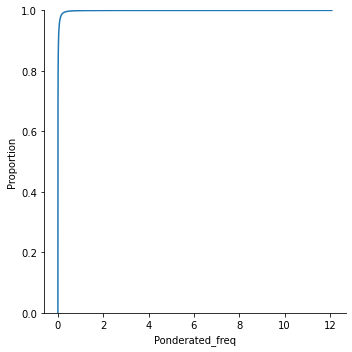

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data=melted_df, x='Ponderated_freq', kind='ecdf')

There are ! We then remove them by filtering 99% of the data

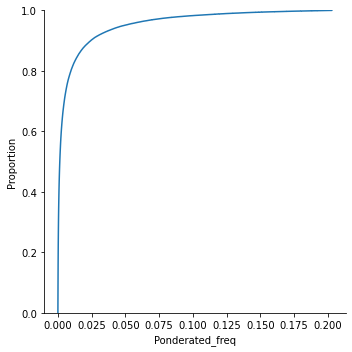

In [63]:
# We calculate the quantile then we remove from the dataset
q_freq = melted_df['Ponderated_freq'].quantile(q=0.99)
filtered_melted_df = melted_df.loc[melted_df['Ponderated_freq'] <= q_freq]

# And we plot it
sns.displot(data=filtered_melted_df, x='Ponderated_freq', kind='ecdf')

Now we can plot our data easily !

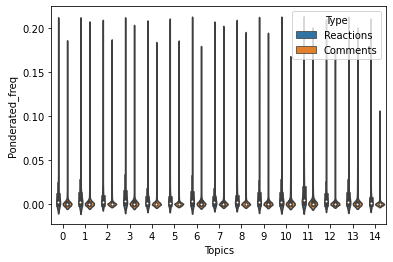

In [65]:
ax = sns.violinplot(data=filtered_melted_df, x="Topics", y="Ponderated_freq", hue='Type')



The result is not relevant ....

Let's try with normalizing the reactions and comments

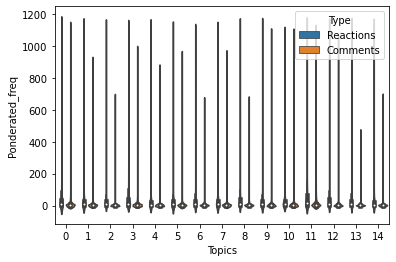

In [71]:
# Let's create vectors for reactions, commens & followers
reactions = np.array(df_topics_reactions["#Reactions"])
comments = np.array(df_topics_reactions["#Comments"])
followers = np.array(df_topics_reactions['Followers'])

# We create the array of topics frequency
# We take the last columns of the df, which correspond to the number of topics
topic_freq = np.array(df_topics_reactions.iloc[:,-num_topics:])

# Let's declare our array that has the same shape as topic_freq
ponderated_reactions = np.zeros(shape=topic_freq.shape)
ponderated_comments = np.zeros(shape=topic_freq.shape)

# And we ponderate each reactions & comments with topic frequencies
for i in range(len(reactions_normalized)):
    ponderated_reactions[i,:] = np.dot(reactions[i],topic_freq[i,:])
    ponderated_comments[i,:] = np.dot(comments[i],topic_freq[i,:])
    
# Now let's concat ths array as a dataframe to our author dataframe
author_df = df_topics_reactions['Name']

# We create new dataframes with topics frequencies ponderated with reactions & comments normalized
ponderated_reactions_df = pd.DataFrame(data=ponderated_reactions,columns=range(num_topics))
ponderated_comments_df = pd.DataFrame(data=ponderated_comments,columns=range(num_topics))

# Then we create two dataframe which are the concatenation of authors & reactions/comments respectively
final_reactions_df = pd.concat([author_df,ponderated_reactions_df],axis=1)
final_comments_df = pd.concat([author_df,ponderated_comments_df],axis=1)

# Now we can calculate the mean and the variance of topics ponderated reactions/comments depending on the author
# We calculate the mean of the mean of the number of normalized reactions by topic by author
# We get a vector of reactions for each topics
topics_reactions_mean = final_reactions_df.groupby(by="Name").mean().mean(axis=0)

# We do the same for comments
topics_comments_mean = final_comments_df.groupby(by='Name').mean().mean(axis=0)
# Let's do the same for the variance
topics_reactions_var = final_reactions_df.groupby(by="Name").mean().var(axis=0)
topics_comments_var = final_comments_df.groupby(by='Name').mean().var(axis=0)
# We use the function melt
melted_reactions_df = final_reactions_df.melt(id_vars="Name",value_vars=final_reactions_df.columns,var_name="Topics",value_name="Ponderated_freq")
# We remove useless 0's
melted_reactions_df = melted_reactions_df.loc[melted_reactions_df['Ponderated_freq'] != 0]
# We add a column to inform that this dataset in reactions
melted_reactions_df['Type'] = "Reactions"

# We do the same for comments
melted_comments_df = final_comments_df.melt(id_vars="Name",value_vars=final_comments_df.columns,var_name="Topics",value_name="Ponderated_freq")
# We remove useless 0's
melted_comments_df = melted_comments_df.loc[melted_comments_df['Ponderated_freq'] != 0]
# We add a column to inform that this dataset in comments
melted_comments_df['Type'] = "Comments"

# Then we concat df's
melted_df = pd.concat([melted_reactions_df, melted_comments_df],axis=0)
melted_df.reset_index(inplace=True,drop=True)

# # We calculate the quantile then we remove from the dataset
q_freq = melted_df['Ponderated_freq'].quantile(q=0.99)
filtered_melted_df = melted_df.loc[melted_df['Ponderated_freq'] <= q_freq]

#Plot
ax = sns.violinplot(data=filtered_melted_df, x="Topics", y="Ponderated_freq", hue="Type")



Let's see for one author

In [75]:
filtered_melted_df.Name.unique()

array(['Nicholas Wyman', 'Jonathan Wolfer', 'Karen Gross',
       'Kaia Niambi Shivers Ph.D.', "Daniel Cohen-I'm Flyering",
       'Natalie Riso', 'James Calder', 'Yasi Baiani', 'Julie Kliger',
       'Michelle de Haaff', 'Bertalan Meskó, MD, PhD', 'Michelle Chaffee',
       'Beth Seidenberg', 'Russell Benaroya', 'Richard Branson',
       'Mohamed El-Erian', 'James Altucher', 'Bernard Marr',
       'Ian Bremmer', 'Sramana Mitra', 'Lynne Everatt', 'Justin Bariso',
       'Carson Tate', 'Gary Frisch', 'James Bareham', 'Tai T.',
       'Glenn Leibowitz', 'Marianne Griebler', 'Tom Goodwin',
       'Katie Martell', 'Shama Hyder', 'Barry W. Enderwick',
       'Steve Blakeman', 'Gillian Zoe Segal', 'Tom Foremski',
       'Kiara Imani Williams, Esq.', 'Kellye Whitney', 'Simon Owens',
       'Rachel Jones', 'Vikram Mansharamani', '🏉 Pascal Bouvier',
       'Geoffrey Garrett', 'Ben Casselman', 'Tamal Bandyopadhyay',
       'Karen Webster', 'Jody Padar', 'Hansi Mehrotra', 'Nick Ciubotariu',
     

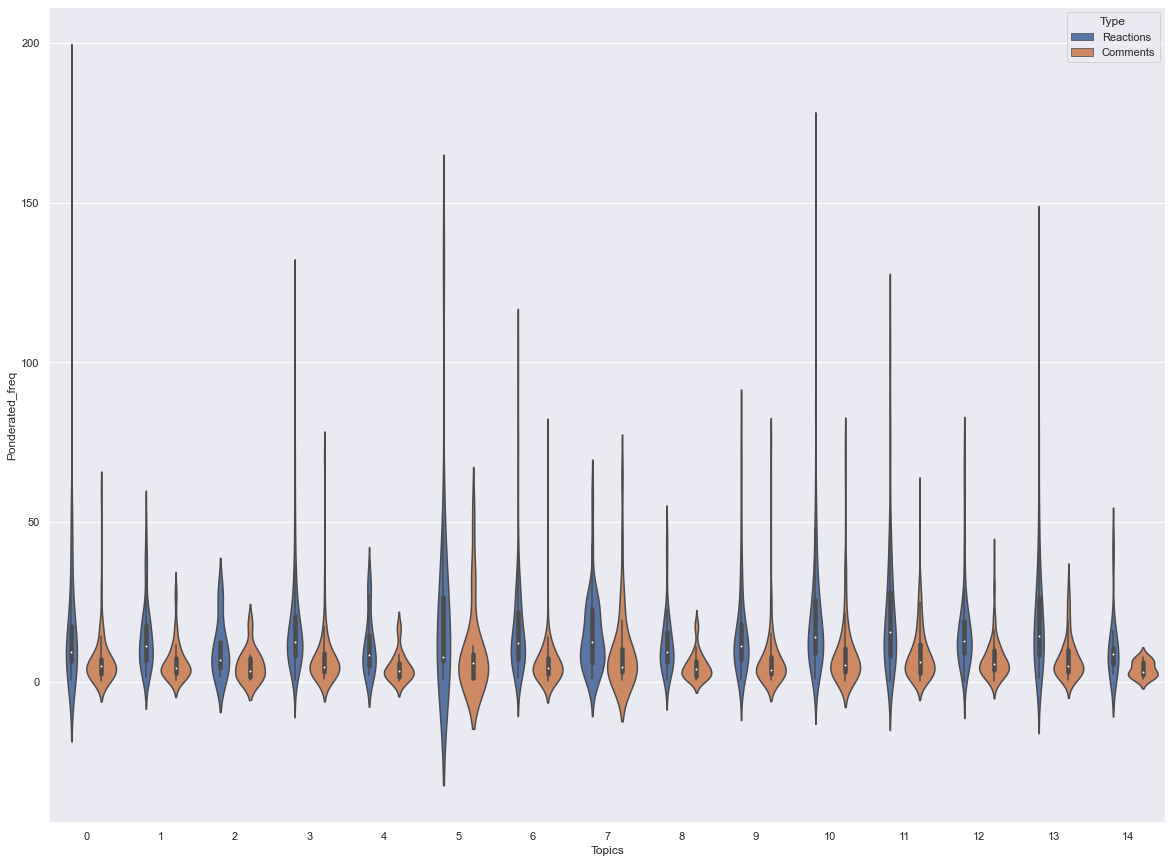

In [77]:
one_author_df = filtered_melted_df.loc[filtered_melted_df['Name']=="String Nguyen"]
ax = sns.violinplot(data=one_author_df, x="Topics", y="Ponderated_freq", hue="Type")

sns.set(rc={'figure.figsize':(20,15)})